# Self-Driving Car Engineer

## Lucas Gago

## Machine Learning

## Project: Vehicle Detection

In [35]:
import numpy as np
import cv2
import glob
import os
import pickle
import fnmatch

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from scipy.ndimage.measurements import label
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import glob
from time import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

from IPython.core.display import Image, display
from moviepy.editor import VideoFileClip
from IPython.display import HTML


import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


%matplotlib inline

## Camera Calibration

---

In [36]:
%%time
a=0
for i in range(100000000):
    a+=1
    

Wall time: 10 s


In [37]:
def calibrate_camera(cal_images, nx, ny):
    imge=[]
    orig=[]
    objpoints=[]  # 3D points
    imgpoints=[]  # 2D points

    objp=np.zeros((nx*ny,3), np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname=cal_images[0]
    for fname in cal_images:
        img=cv2.imread(fname)
        gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners=cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            imge.append(cv2.drawChessboardCorners(img, (9,6), corners, ret))
            
    ret, mtx, dist, rvecs, tvecs=cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist,imge

In [38]:
def camera_setup():
    cal_images=glob.glob('camera_cal/calibration*.jpg')
    nx, ny=9, 6
    cam_mtx, cam_dist,imge= calibrate_camera(cal_images, nx, ny)
    return cam_mtx, cam_dist,imge

In [39]:
cam_mtx, cam_dist,imge= camera_setup()

## Load the dataset
---

In [40]:
cars_data = []
for filename in glob.glob('vehicles/*.png'):
    img=cv2.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cars_data.append(img)
    
non_cars_data = []
for filename in glob.glob('non_vehicles/*.png'):
    img=cv2.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    non_cars_data.append(img)

In [58]:
def show_Grid(X,Y):
    h=len(X)
    w=2
    features_example=[]
    plt.figure(figsize=(20,h*6))
    gs1=gridspec.GridSpec(h,w)
    gs1.update(wspace=0.002, hspace=0.2)
    count=0
    for i in range(h):
        ax1=plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        count+=1
        plt.imshow(X[i])
        ax1=plt.subplot(gs1[count])
        plt.axis('on')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        plt.imshow(Y[i])
        count+=1
    plt.show()



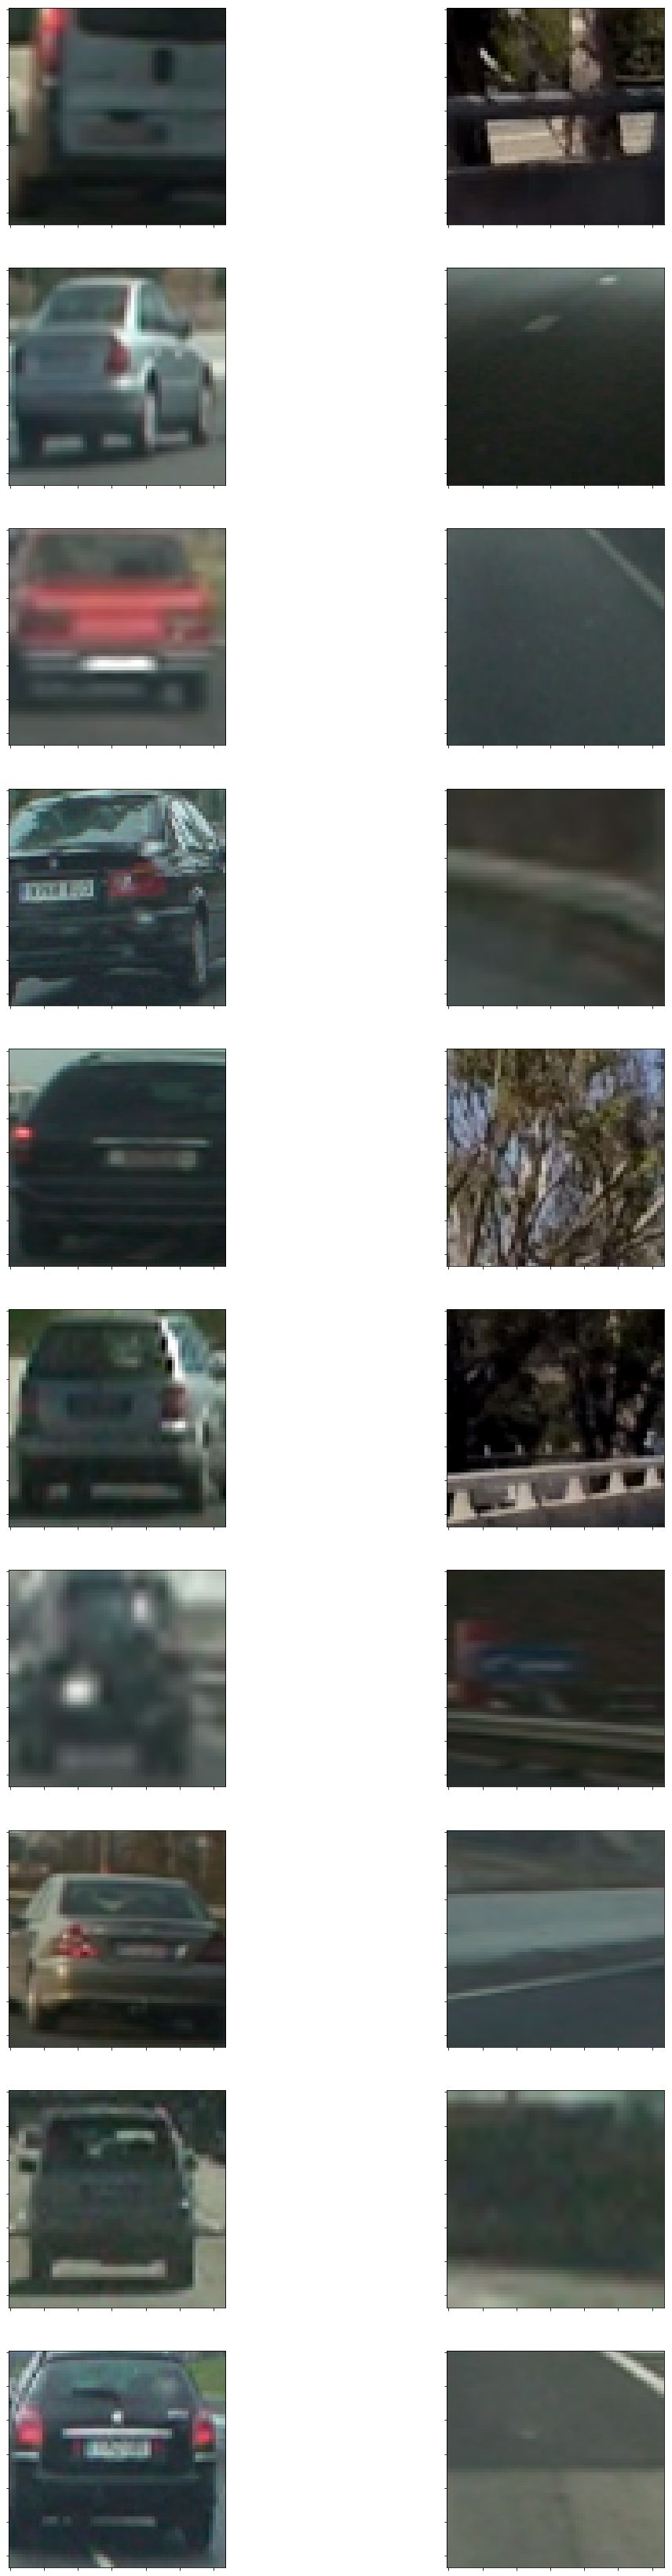

In [60]:
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec

cars_data = shuffle(cars_data)
non_cars_data = shuffle(non_cars_data)
cars_example=[]
non_cars_example=[]
for i in range(10):
    cars_example.append(cars_data[i])
    non_cars_example.append(non_cars_data[i])
    
show_Grid(cars_example,non_cars_example)
    

### Train the model
---

In [41]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

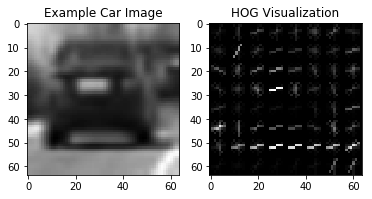

In [42]:
gray = cv2.cvtColor(cars_data[0], cv2.COLOR_RGB2GRAY)

orient = 9
pix_per_cell = 8
cell_per_block = 2

features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [43]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [44]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [45]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Selection of best HOG features for classification

In [46]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


sample_size = 2400  # Reduce for better performance
cars= cars_data[0:sample_size]
non_cars = non_cars_data[0:sample_size]

t=time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
t2 = time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()

t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time()

18.42 Seconds to extract HOG features...
Using: 7 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
0.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9948


## Check simple NN performance
---

In [48]:
seed = 7
numpy.random.seed(seed)

In [55]:
def create_baseline():
    model = Sequential()
    model.add(Dense(60, input_dim=len(X_train[0]), init='normal', activation='relu'))
    model.add(Dense(30, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [70]:
%%time
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (max(results)*100, results.std()*100))

Results: 99.45% (0.34%)
Wall time: 14min 2s


In [73]:
print("Best Result: %.2f%% (%.2f%%)" % (max(results)*100, results.std()*100))

Best Result: 99.79% (0.34%)


## Try using different ML classifiers
---

In [47]:
def predict_labels_accuracy(clf, features, target):
    
    y_pred = clf.predict(features)
    
    return accuracy_score(target, y_pred)   

def train_predict(clf, X_train, y_train, X_test, y_test):
    
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    clf.fit(X_train, y_train)
    print ("Accuracy score for training set: {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
    print ("Accuracy score for test set: {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

In [52]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process","Decision Tree", "Random Forest", "Neural Net", "AdaBoost","Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for clf in classifiers:
    print ("\n{}: \n".format(clf.__class__.__name__))
    for n in [2400]:
        train_predict(clf, X_train[:n], y_train[:n], X_test, y_test)
        print ('-'*32)


KNeighborsClassifier: 

Training a KNeighborsClassifier using a training set size of 2400. . .
Accuracy score for training set: 0.9896.
Accuracy score for test set: 0.9719.
--------------------------------

SVC: 

Training a SVC using a training set size of 2400. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.9938.
--------------------------------

SVC: 

Training a SVC using a training set size of 2400. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.5021.
--------------------------------

GaussianProcessClassifier: 

Training a GaussianProcessClassifier using a training set size of 2400. . .
Accuracy score for training set: 1.0000.
Accuracy score for test set: 0.5031.
--------------------------------

DecisionTreeClassifier: 

Training a DecisionTreeClassifier using a training set size of 2400. . .
Accuracy score for training set: 0.9779.
Accuracy score for test set: 0.9448.
--------------------------------

RandomForestClassi

|Clasificator   	| Training  	|  Test 	|
|---	|---	|---	|
|  KNeighborsClassifier 	|  0.9896 	|   .9719	|
|SVC(kernel="linear", C=0.025)   	|  1.0000 	|  .9938 |
| SVC(gamma=2, C=1)  	| 1.0000  	|  0.5021 	|
| GaussianProcessClassifier  	| 1.0000  	|  0.5031 	|
| DecisionTreeClassifier  	| 0.9779  	|  0.9448 	|
| RandomForestClassifier  	| 0.9129  	| 0.8750  	|
| MLPClassifier  	|  1.0000 	|  0.9969 	|
| AdaBoostClassifier  	|  1.0000 	|  0.9875 	|
|  GaussianNB 	|   0.9646	|   0.9594	|
|QuadraticDiscriminantAnalysis| 1.0000|0.5802|


## Optimize the SVM parameters by using grid search cross validation
---

In [ ]:
%%time


parameters = {'kernel':('linear', 'rbf','sigmoid'), 'C':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
              'gamma':[.000001,.000005,.00005,.0005,.001,.005,.01,.02,.04,.05,.1,.3,.5]}


clf = SVC(random_state=3)

grid_obj = GridSearchCV(clf, parameters)

opt_size=1000
grid_obj.fit(X_train[:opt_size],y_train[:opt_size])

clf = grid_obj.best_estimator_

print ("Tuned model has a training accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
print ("Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

print("The best parameters are %s" % (grid_obj.best_params_))

np.savetxt("eval-SVM.csv", clf.predict(X_test), delimiter=",")

Tuned model has a training accuracy score of 0.9932.

Tuned model has a testing accuracy score of 0.9917.

The best parameters are {'gamma': 5e-05, 'kernel': 'rbf', 'C': 2}

CPU times: user 49min 14s, sys: 0 ns, total: 49min 14s

Wall time: 49min 14s

## Optimize the MLP parameters by using grid search cross validation
---

In [51]:
%%time


parameters = {"activation":("identity", "logistic", "tanh", "relu"), "solver" : ("lbfgs", "sgd", "adam"),"alpha":[1,0.1,0.001,0.0001,0.00001]}


clf = MLPClassifier()

grid_obj = GridSearchCV(clf, parameters)

opt_size=1000
grid_obj.fit(X_train[:opt_size],y_train[:opt_size])

clf = grid_obj.best_estimator_

print ("Tuned model has a training accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_train, y_train)))
print ("Tuned model has a testing accuracy score of {:.4f}.".format(predict_labels_accuracy(clf, X_test, y_test)))

print("The best parameters are %s" % (grid_obj.best_params_))

np.savetxt("eval-MLP.csv", clf.predict(X_test), delimiter=",")

Tuned model has a training accuracy score of 0.9940.
Tuned model has a testing accuracy score of 0.9885.
The best parameters are {'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 1}
Wall time: 25min 35s


## Check performance on full dataset

In [55]:
svc = SVC(kernel='rbf', C=2, gamma= 5e-05)
# Check the training time for the SVC
t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t3=time()
print(round(t3-t, 2), 'Seconds to test accuracy...')

17.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9948
21.62 Seconds to test accuracy...


In [54]:
svc = MLPClassifier(alpha=1)
# Check the training time for the SVC
t=time()
svc.fit(X_train, y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t3=time()
print(round(t3-t, 2), 'Seconds to test accuracy...')

22.87 Seconds to train SVC...
Test Accuracy of SVC =  0.9969
22.91 Seconds to test accuracy...


## Sliding Windows
---

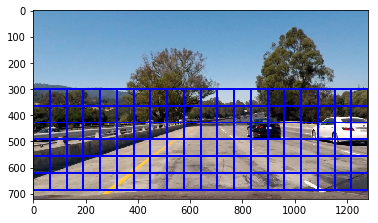

In [16]:
image = mpimg.imread('./examples/test1.jpg')
image=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[300, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [17]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    


In [18]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

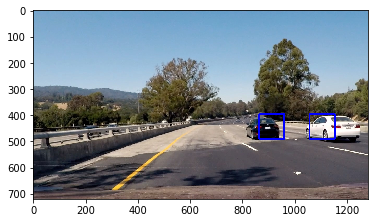

In [19]:
image = mpimg.imread('./examples/test4.jpg')
draw_image = np.copy(image)
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 7  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, None] # Min and max in y to search in slide_window()

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


Wall time: 686 ms


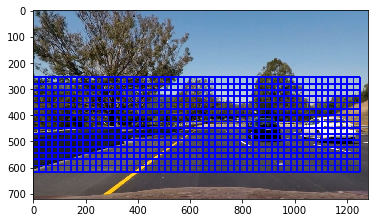

In [20]:
%%time
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img_tosearch = draw_image[ystart:ystop,:,:]
    img = img_tosearch.astype(np.float32)/255


    ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 256
ystop = 656
scale = 1.5

image = mpimg.imread('./examples/test6.jpg')
image=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

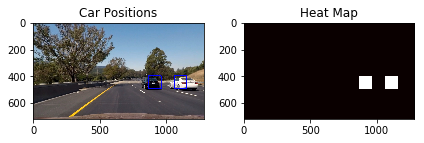

In [21]:

# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## Opencv Haar Classifier
---

In [76]:
class VideoProcessorHaar:
    def __init__(self):
        self._frame_index = 0
        self._FRAME_AGGREGATE = 10
        self._detection_list_total = None
        self._bbox_list_recent = None
        self._threshold = 2
        
    
    def _aggregate_detections(self, detections_):
        if self._detection_list_total is None:
            self._detection_list_total = detections_
        else:
            self._detection_list_total.extend(detections_)

    def process_frame(self, cars,image):
        # find detections
        

        #detections, _ = non_max_suppress(image.shape, detections, 1)

        # aggregate detections
        self._aggregate_detections(cars)
        
        # increment frame number
        self._frame_index += 1
        
        # if we have enough frames...
        if self._frame_index%self._FRAME_AGGREGATE == 0:
            # get aggregate bboxes
            self._bbox_list_recent = non_max_suppress(image, self._detection_list_total,
                                                         self._threshold)
            # reset the detections
            self._detection_list_total = None 
        # if we have bboxes... 
        if self._bbox_list_recent is not None:
            result = draw_boxes(image, self._bbox_list_recent, color=(0, 0, 255), thick=6)
            return result
        else:
            return image

In [77]:
cascade_src = 'cars.xml'
video_src = 'project_video.mp4'
#video_src = 'dataset/video2.avi'

cap = cv2.VideoCapture(video_src)
car_cascade = cv2.CascadeClassifier(cascade_src)

while True:
    v=VideoProcessorHaar()
    ret, img = cap.read()
    if (type(img) == type(None)):
        break
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    cars = car_cascade.detectMultiScale(gray,scaleFactor = 1.1 ,minNeighbors = 2,
            minSize = (130, 130),maxSize = (330, 330), flags = cv2.CASCADE_SCALE_IMAGE)
    res=v.process_frame(cars,img)
    for (x,y,w,h) in cars:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)      
    
    cv2.imshow('video', res)
    
    if cv2.waitKey(33) == 27:
        break

cv2.destroyAllWindows()

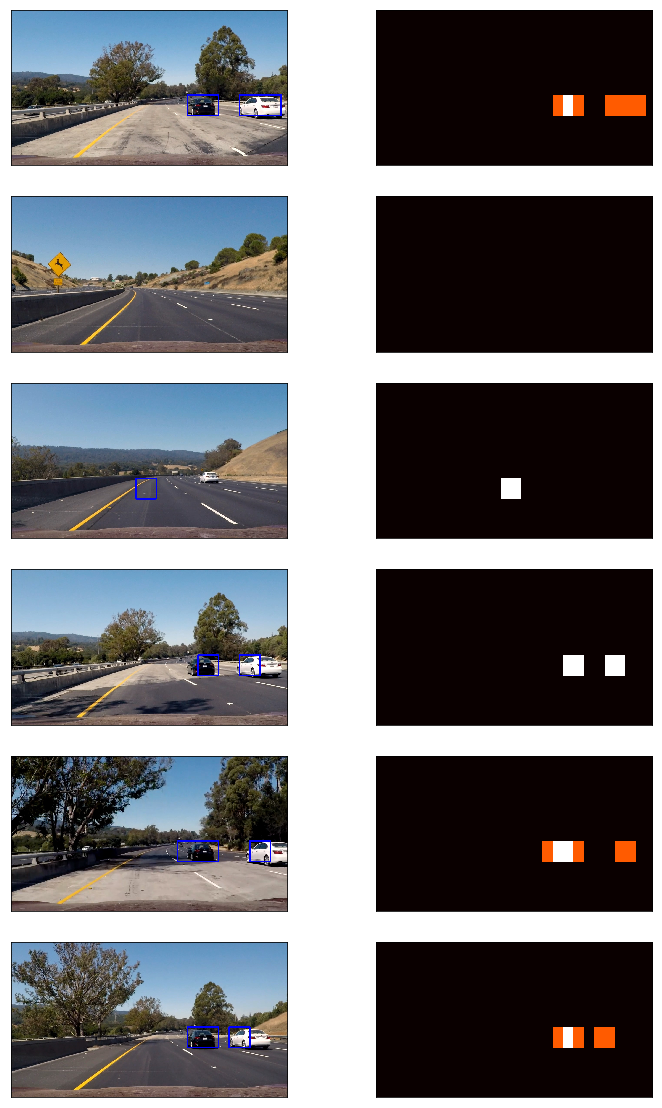

In [22]:
test_dir = os.getcwd() + '/test_images'
output_dir = os.getcwd() + '/output_images'
fig = plt.figure(figsize=(12, 20))
elem = 1
for file in os.listdir(test_dir):
    if not fnmatch.fnmatch(file, "*.jpg"):
        continue
    filename = os.path.join(test_dir, file)
    image = mpimg.imread(filename)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

        # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    
    ax = fig.add_subplot(6, 2, elem)
    ax.imshow(draw_img)
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    elem += 1
    ax = fig.add_subplot(6, 2, elem)
    ax.imshow(heatmap, cmap='hot')
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    elem += 1

In [120]:
def process_image(imagen):
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 7  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [300, None] # Min and max in y to search in slide_window()
    
    windows = slide_window(imagen, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(imagen, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  
    return hot_windows

def non_max_suppress(imagen,hot_windows,thres):
    heat = np.zeros_like(imagen[:,:,0]).astype(np.float)

        # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,thres)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(imagen), labels)
    return draw_img

In [24]:
def complete(image):
    return non_max_suppress(image,process_image(image),0)

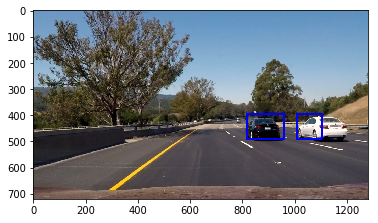

In [25]:
plt.imshow(non_max_suppress(image,process_image(image),0))

In [121]:
class VideoProcessor:
    def __init__(self):
        self._frame_index = 0
        self._FRAME_AGGREGATE = 5
        self._detection_list_total = None
        self._bbox_list_recent = None
        self._threshold = 3
        
    
    def _aggregate_detections(self, detections_):
        if self._detection_list_total is None:
            self._detection_list_total = detections_
        else:
            self._detection_list_total.extend(detections_)

    def process_frame(self, image):
        # find detections
        image=process_image_P4(image)
        detections = process_image(image)

        #detections, _ = non_max_suppress(image.shape, detections, 1)

        # aggregate detections
        self._aggregate_detections(detections)
        
        # increment frame number
        self._frame_index += 1
        
        # if we have enough frames...
        if self._frame_index%self._FRAME_AGGREGATE == 0:
            # get aggregate bboxes
            self._bbox_list_recent, _ = non_max_suppress(image, self._detection_list_total,
                                                         self._threshold)
            # reset the detections
            self._detection_list_total = None 
        # if we have bboxes... 
        if self._bbox_list_recent is not None:
            result = draw_boxes(image, self._bbox_list_recent, color=(0, 0, 255), thick=6)
            return result
        else:
            return image

In [122]:
def test(img):
    return img

In [129]:
output_video = 'output.mp4'
clip1 = VideoFileClip("test_video.mp4").subclip(0,1)
video_processor = VideoProcessor()

#processed_clip = clip1.fl_image(complete) #NOTE: this function expects color images!!


processed_clip = clip1.fl_image(video_processor.process_frame) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4




  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

  4%|███▏                                                                               | 1/26 [00:01<00:41,  1.67s/it]

  8%|██████▍                                                                            | 2/26 [00:03<00:39,  1.66s/it]

 12%|█████████▌                                                                         | 3/26 [00:04<00:38,  1.65s/it]

ValueError: too many values to unpack (expected 2)

In [124]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [125]:
def process_image_P4(image,yellow_low=np.array([0,100,100]),yellow_high=np.array([-0.0001,0,1000]),
                  white_low=np.array([-0.0001,0,400]),white_high=np.array([-0.0001,0,1000])   ,
                  sobel_kernel=9,min_thres=80, max_thres =220,min_slope=0,max_slope=.5):

    img_undist=cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)
    global counter
    global center_data
    global ref_left 
    global ref_right
    global left_fit
    global right_fit
    img_size=(image.shape[1], image.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])


    src=np.rint(src)
    dst=np.rint(dst)
    M_persp=cv2.getPerspectiveTransform(src, dst)
    Minv_persp=cv2.getPerspectiveTransform(dst, src)
    

    imgThres_yellow=hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white=hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx=sobel_x(img_undist,sobel_kernel,min_thres ,max_thres) #Sobel x

    img_mag_thr =np.zeros_like(imgThres_yellow)
    img_mag_thr[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
        
    img_size=(img_mag_thr.shape[1], img_mag_thr.shape[0])
    binary_warped=cv2.warpPerspective(img_mag_thr, M_persp, img_size, flags=cv2.INTER_LINEAR)
    
    if counter==0:
        left_fit, right_fit,out_imgfit=fitlines(binary_warped)
    else:
        left_fit, right_fit=fit_continuous(left_fit, right_fit, binary_warped)
    
    
    
    status_sanity, d0, d1 =sanity_check(left_fit, right_fit, min_slope, max_slope)
    
    if status_sanity  == True:        
        ref_left,ref_right=left_fit,right_fit        
        counter+=1
    else:     
        left_fit,right_fit=ref_left,ref_right
        
    left_curv, right_curv, center_off=curvature(left_fit, right_fit, binary_warped)
    color=(255,255, 255)
    warp_zero=np.zeros_like(binary_warped).astype(np.uint8)
    color_warp=np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty=np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0] )
    left_fitx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    
    pts_left=np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right=np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts=np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), color)
    newwarp=cv2.warpPerspective(color_warp, Minv_persp, (color_warp.shape[1], color_warp.shape[0])) 
    result=cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    img_merge= result
    img_birds=color_warp

    margin=300
    top_margin=50
    h=300
    img_out=np.zeros((img_size[1],img_size[0],3), dtype=np.uint8)
    
    graph=np.zeros((100,margin,3),dtype=np.uint8)

    center_data.append(center_off)
    graph=cool_visualization(center_data,graph,margin)

    img_out[img_size[1]-h-100:img_size[1]-h,img_size[0]-margin:img_size[0], :] =graph
    img_out[top_margin:img_size[1],0:img_size[0]-margin,0:3] =cv2.resize(img_merge,(img_size[0]-margin,img_size[1]-top_margin))    
    img_out[img_size[1]-h:img_size[1],img_size[0]-margin:img_size[0], 0] =cv2.resize(img_mag_thr*255,(margin,h))
    img_out[img_size[1]-h:img_size[1],img_size[0]-margin:img_size[0], 1] =cv2.resize(img_mag_thr*255,(margin,h))
    img_out[img_size[1]-h:img_size[1],img_size[0]-margin:img_size[0], 2] =cv2.resize(img_mag_thr*255,(margin,h))

    TextL="-Left curvature: "+str(int(left_curv))+" m"
    TextR="-Right curvature: "+str(int(right_curv))+ " m"
    TextC="-Center offset: "+str(round( center_off,2))+"m"
    TextUp="-Updating: "+str(status_sanity)
    TextCent= "-Center_data size: "+str(len(center_data))
    fontScale=.5
    thickness=1
    
    fontFace=cv2.FONT_HERSHEY_TRIPLEX

    cv2.putText(img_out, "DATA", (img_size[0]-margin+100,60), fontFace, .8,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextL, (img_size[0]-margin+20,100), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextR, (img_size[0]-margin+20,130), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextC, (img_size[0]-margin+20,160), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, TextUp, (img_size[0]-margin+20,190), fontFace, fontScale,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    cv2.putText(img_out, "Center offset history", (img_size[0]-margin+70,300), fontFace, .4,(255,255,255), thickness,  lineType=cv2.LINE_AA)

    cv2.putText(img_out, "Lucas Gago                              SDCND P4&5                             v0.8", (5,30), fontFace, .7,(255,255,255), thickness,  lineType=cv2.LINE_AA)
    
    return img_out

def hls_color_thresh(img, thresh_Low, tresh_High):
    imgHSV=cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary=np.zeros((img.shape[0], img.shape[1]))
    binary[(imgHSV[:,:,0] >= thresh_Low[0]) & (imgHSV[:,:,0] <= tresh_High[0])  &
                  (imgHSV[:,:,1] >= thresh_Low[1]) & (imgHSV[:,:,1] <= tresh_High[1])  & 
                  (imgHSV[:,:,2] >= thresh_Low[2]) & (imgHSV[:,:,2] <= tresh_High[2])]=1
                 
    return binary

def sobel_x(img, sobel_kernel=3,min_thres=20, max_thres =100):
    imghsl=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx1=cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2=cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    scl_sobelx1=np.uint8(255*sobelx1/ np.max(sobelx1))
    scl_sobelx2=np.uint8(255*sobelx2/ np.max(sobelx2))
    binaryx1=np.zeros_like(scl_sobelx1)
    binaryx1[(scl_sobelx1 >= min_thres) & (scl_sobelx1 <= max_thres)]=1
    binaryx2=np.zeros_like(scl_sobelx2)
    binaryx2[(scl_sobelx2 >= min_thres) & (scl_sobelx2 <= max_thres)]=1
    binary=np.zeros_like(scl_sobelx1)
    binary[(binaryx1 ==1) | (binaryx2 ==1)]=1
    
    return binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    

    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    gradmag=np.sqrt(sobelx**2+sobely**2)
    scl_sobel=np.uint8(255*gradmag / np.max(gradmag))
    binary=np.zeros_like(scl_sobel)
    binary[(scl_sobel >= mag_thresh[0]) & (scl_sobel <= mag_thresh[1])]=1

    return binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely=cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    absgraddir=np.arctan2(abs_sobely, abs_sobelx) 
    binary=np.zeros_like(absgraddir)
    binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])]=1

    return binary

def mag_dir_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), dir_thresh=(0,np.pi/2)):
    gray=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx=cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel) 
    sobely=cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    gradmag=np.sqrt(sobelx**2+sobely**2)
    abs_sobelx=np.absolute(sobelx)
    abs_sobely=np.absolute(sobely)
    absgraddir=np.arctan2(abs_sobely, abs_sobelx) 
    scl_sobel=np.uint8(255*gradmag / np.max(gradmag))
    binary=np.zeros_like(scl_sobel)
    binary[(scl_sobel >= mag_thresh[0]) & (scl_sobel <= mag_thresh[1]) & (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1]) ]=1

    return binary



def fitlines(binary_warped):
    histogram=np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img=np.dstack((binary_warped, binary_warped, binary_warped))*255
    mid=np.int(histogram.shape[0]/2)
    left_base=np.argmax(histogram[:mid])
    right_base=np.argmax(histogram[mid:])+mid
    nwindows=9
    window_height=np.int(binary_warped.shape[0]/nwindows)
    nonzero=binary_warped.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    leftx_current=left_base
    rightx_current=right_base
    margin=100
    minpix=50
    left_lane_inds=[]
    right_lane_inds=[]

    for window in range(nwindows):
        win_y_low=binary_warped.shape[0]-(window+1)*window_height
        win_y_high=binary_warped.shape[0]-window*window_height
        win_xleft_low=leftx_current-margin
        win_xleft_high=leftx_current+margin
        win_xright_low=rightx_current-margin
        win_xright_high=rightx_current+margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,0), 2) 
        good_left_inds=((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds=((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:  leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix: rightx_current=np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds=np.concatenate(left_lane_inds)
    right_lane_inds=np.concatenate(right_lane_inds)

    leftx=nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds] 
    rightx=nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds] 
    
    
    left_fit =[] if len(leftx) == 0 else np.polyfit(lefty, leftx, 2)
    right_fit =[] if len(rightx) == 0 else np.polyfit(righty, rightx, 2)
        
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]]=[255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]]=[0, 0, 255]


    return left_fit, right_fit,out_img

def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    xm_per_pix=3.7/700 
    if len(left_fit) ==0 or len(right_fit) == 0:
        status=False
        d0=0
        d1=0
    else:
        L_0=2*left_fit[0]*460+left_fit[1]
        R_0=2*right_fit[0]*460+right_fit[1]
        d0= np.abs(L_0-R_0)

        L_1=2*left_fit[0]*img_size[0]+left_fit[1]
        R_1=2*right_fit[0]*img_size[0]+right_fit[1]
        d1= np.abs(L_1-R_1)

        
        status=True if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope else False
    
    return(status, d0, d1)


def curvature(left_fit, right_fit, binary_warped):
    ploty=np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval=np.max(ploty)
    
    ym_per_pix=30/img_size[0] 
    xm_per_pix=3.7/700 

    left_curverad=((1+(2*left_fit[0]*y_eval*ym_per_pix+left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad=((1+(2*right_fit[0]*y_eval*ym_per_pix+right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center=(((left_fit[0]*img_size[0]**2+left_fit[1]*img_size[0]+left_fit[2]) +(right_fit[0]*img_size[0]**2+right_fit[1]*img_size[0]+right_fit[2]) ) /2-640)*xm_per_pix
    
    return left_curverad, right_curverad, center

def cool_visualization(center_data,graph,margin):
    maxlen=55
    if len(center_data)>maxlen:
        center_data.pop(0)
    pts=center_data
    for i in range(1, len(center_data)):
        if center_data[i-1] is None or center_data[i] is None:
            continue    
        if i==len(center_data)-1:
            thickness=4 
        elif i==len(center_data)-2:
            thickness=3
        else:
            thickness=2
        cv2.line(graph, (4*i-4,50-int(100*center_data[i-1])), (4*i,50-int(100*center_data[i])), (255, 0, 0), thickness)
    graph=cv2.line(graph,(0,50),(margin,50),(255,255,0),2)    
    return graph

def fit_continuous(left_fit, right_fit, binary_warped):
    nonzero=binary_warped.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    margin=100
    left_lane_inds=((nonzerox > (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2]-margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2]+margin))) 
    right_lane_inds=((nonzerox > (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]-margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]+margin)))  

    leftx=nonzerox[left_lane_inds]
    lefty=nonzeroy[left_lane_inds] 
    rightx=nonzerox[right_lane_inds]
    righty=nonzeroy[right_lane_inds]
    
    left_fit_updated =[] if len(leftx) == 0 else np.polyfit(lefty, leftx, 2)
    right_fit_updated =[] if len(rightx) == 0 else np.polyfit(righty, rightx, 2)
    
    return  left_fit_updated, right_fit_updated
global center_data
global counter
center_data=[]
counter=0

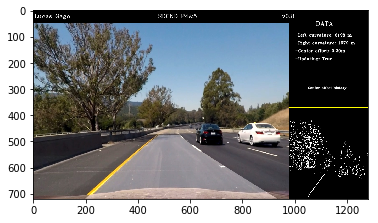

In [127]:
plt.imshow(process_image_P4(image))